## Imports and Functions

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import sscPhantom
import numpy
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
from tqdm import tqdm
from scipy.ndimage import rotate
from PIL import Image
from matplotlib.colors import LogNorm
import json

In [163]:
def read_probe_positions(path,filename):
    print('Reading probe positions (probe_positions)...')
    probe_positions = []
    positions_file = open(os.path.join(path,'positions',f"{filename}_001.txt"))

    line_counter = 0
    for line in positions_file:
        line = str(line)
        if line_counter >= 1:  # skip first line, which is the header
            T = 3e-3  # why did Giovanni rotated by this amount? not using this correction seems to result in an error in the number of positions
            pxl = float(line.split()[1])
            pyl = float(line.split()[0])
            px = pxl * np.cos(T) - np.sin(T) * pyl
            py = pxl * np.sin(T) + np.cos(T) * pyl
            probe_positions.append([px, py, 1, 1])
        line_counter += 1

    probe_positions = np.asarray(probe_positions)

    return probe_positions

def convert_probe_positions(dx, probe_positions, offset_topleft = 20):
    """Set probe positions considering maxroi and effective pixel size

    Args:
        difpads (3D array): measured diffraction patterns
        jason (json file): file with the setted parameters and directories for reconstruction
        probe_positions (array): each element is an 2-array with x and y probe positions
        offset_topleft (int, optional): [description]. Defaults to 20.

    Returns:
        object pixel size (float), maximum roi (int), probe positions (array)
    """    

    # Subtract the probe positions minimum to start at 0
    probe_positions[:, 0] -= np.min(probe_positions[:, 0])
    probe_positions[:, 1] -= np.min(probe_positions[:, 1])

    offset_bottomright = offset_topleft #define padding width
    probe_positions[:, 0] = 1E-6 * probe_positions[:, 0] / dx + offset_topleft #shift probe positions to account for the padding
    probe_positions[:, 1] = 1E-6 * probe_positions[:, 1] / dx + offset_topleft #shift probe positions to account for the padding

    return probe_positions, offset_bottomright

def set_object_shape(probe,dx,probe_positions, offset_topleft = 20):

    # Compute half size of diffraction patterns:
    half_size = probe.shape[-1] // 2

    probe_positions, offset_bottomright = convert_probe_positions(dx, probe_positions, offset_topleft = offset_topleft)

    maxroi        = int(np.max(probe_positions)) + offset_bottomright
    object_shape  = 2 * half_size + maxroi
    print('Object shape:',object_shape)

    return (object_shape,object_shape)

In [230]:
def match_colorbar(ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

def RemoveGrad_new( img, mask ):
    xy = numpy.argwhere( mask > 0)
    n = len(xy)
    y = xy[:,0].reshape([n,1])
    x = xy[:,1].reshape([n,1])
    F = numpy.array([ img[y[k],x[k]] for k in range(n) ]).reshape([n,1])
    mat = numpy.zeros([3,3])
    vec = numpy.zeros([3,1])
    mat[0,0] = (x*x).sum()
    mat[0,1] = (x*y).sum()
    mat[0,2] = (x).sum()
    mat[1,0] = mat[0,1]
    mat[1,1] = (y*y).sum()
    mat[1,2] = (y).sum()
    mat[2,0] = mat[0,2]
    mat[2,1] = mat[1,2]
    mat[2,2] = n
    vec[0,0] = (x*F).sum()
    vec[1,0] = (y*F).sum()
    vec[2,0] = (F).sum()
    eye = numpy.eye(mat.shape[0])
    eps = 1e-5 # valor tirado do *
    if 1: # com regularização
        abc = numpy.dot( numpy.linalg.inv(mat + eps * eye), vec).flatten() 
    else: # sem regularização
        abc = numpy.dot( numpy.linalg.inv(mat), vec).flatten()
    a = abc[0]
    b = abc[1]
    c = abc[2]
    new   = numpy.zeros(img.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    new[y, x] = img[ y, x] - ( a*XX[y,x] + b*YY[y,x] + c )
    print('Fitted',a,b,c)
    #for k in range(n):
    #    new[y[k], x[k]] = img[ y[k], x[k]] - ( a*x[k] + b*y[k] + c )
    return new, a,b,c

def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def get_scan_step(oversampling,pixel_size,wavelength,distance):
    return wavelength*distance/(oversampling*pixel_size)

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def get_positions(scan_step,size_x,size_y):

    x_positions = np.arange(0,size_x,scan_step)
    y_positions = np.arange(0,size_y,scan_step)

    error = 0.05
    error2 = error
    
    x_pos = x_positions + np.random.normal(scale=error*scan_step,size=x_positions.shape)
    y_pos = y_positions + np.random.normal(scale=error*scan_step,size=y_positions.shape)

    x_pos_error = x_positions + np.random.normal(scale=error2*scan_step,size=x_positions.shape)
    y_pos_error = y_positions + np.random.normal(scale=error2*scan_step,size=y_positions.shape)

    return y_pos,x_pos, y_pos_error,x_pos_error

def set_object_size(x_pos,y_pos,obj_pxl_size,probe_size):
    gap = 10
    return (np.int(gap + probe_size[0]+(np.max(y_pos)-np.min(y_pos))//obj_pxl_size),np.int(gap+probe_size[1]+(np.max(x_pos)-np.min(x_pos))//obj_pxl_size))


def calculate_diffraction_pattern(idx,obj,probe,wavelength,distance,obj_pxl):
    y,x = idx
    # probe = np.ones_like(probe)
    wavefront_box = probe*obj[y:y+probe.shape[0],x:x+probe.shape[1]]
    # DP = wavefront_box
    """ Calculate Difpad """ 
    DP = np.abs(propagate_beam(wavefront_box, (obj_pxl,wavelength,distance)))**2
    return DP

def save_angles_file_CAT_standard():
    for i, angle_number in enumerate(range(tomogram.shape[0])): 
        filename = str(angle_number).zfill(4)+f"_complex_phantom_001.txt"
        line = f"Ry: {angles[i]}\tPiezoB2\tPiezoB3\tPiezoB1\t"
        # print(line)
        with open(os.path.join(path,filename), 'w') as f:
            f.write(line)
            
def save_positions_file_CAT_standard(x,y,path,filename):
    # print(x.shape,y.shape)
    line = f"Ry: {0}\tPiezoB2\tPiezoB3\tPiezoB1\t"
    f = open(os.path.join(path,'positions',f"{filename}_001.txt"), 'w')
    y,x = np.meshgrid(y*1e6,x*1e6) # save in microns
    f.write(line)
    # columns = np.c_[y.flatten(),x.flatten()]
    columns = np.c_[x.flatten(),y.flatten()]
    for i in range(columns.shape[0]):
        f.write(f"\n{columns[i,0]}\t{columns[i,1]}")
    f.close()

import h5py 
def create_hdf_file(matrix,path,filename):
    difpads = np.ones((10,5,3))
    hdf_file = h5py.File(os.path.join(path,'scans',f'{filename}_001.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=matrix)
    hdf_file.close()
    
def get_difpads(frame,probe,distance,energy,probe_pxl,real_space_shape,filename,path,oversampling=3):
    
    speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]

    wavelength = planck * speed_of_light / energy # meters

    obj_pxl = get_object_pixel(probe.shape[0],probe_pxl,wavelength, distance) # energy keV; distance meters
    print("Object pixel size: [m]",obj_pxl)
    
    scan_step = get_scan_step(oversampling,probe_pxl,wavelength,distance)
    print("Scan step size: [m]",scan_step)

    size_y, size_x = obj_pxl*real_space_shape[0], obj_pxl*real_space_shape[1]
    y_pos, x_pos, y_pos_error,x_pos_error = get_positions(scan_step,size_x,size_y)
    print("Positions x: ",x_pos)
    print("Positions y: ",y_pos)
    
    """ Save positions file """
    save_positions_file_CAT_standard(x_pos,y_pos,path,filename)
    probe_positions = read_probe_positions(path,filename)

    # obj_recon_size = set_object_shape(probe,obj_pxl,probe_positions, offset_topleft = 20)
    obj_recon_size = set_object_size(x_pos,y_pos,obj_pxl,probe.shape)

    obj = np.ones(obj_recon_size,dtype=complex)
    print("Object size: ",obj.shape)
    obj[probe.shape[0]//2:probe.shape[0]//2+frame.shape[0],probe.shape[1]//2:probe.shape[1]//2+frame.shape[1]] = frame

    
    # probe_positions, _ = convert_probe_positions(obj_pxl, probe_positions)
    # y_pos_pxl = probe_positions[:,1]
    # x_pos_pxl = probe_positions[:,0]
    x_pos_pxl = [np.int(x) for x in np.round((x_pos-np.min(x_pos))/obj_pxl)]
    y_pos_pxl = [np.int(y) for y in np.round((y_pos-np.min(y_pos))/obj_pxl)]   

    Ymesh, Xmesh = np.meshgrid(y_pos_pxl,x_pos_pxl)

    """ Loop through positions """ 
    difpads = np.zeros((Xmesh.flatten().shape[0],1,probe.shape[0],probe.shape[1]))
    counter = 0
    calculate_diffraction_pattern_partial = partial(calculate_diffraction_pattern,obj=obj,probe=probe,wavelength=wavelength,distance=distance,obj_pxl=obj_pxl)
    idx_list = [ [x,y] for y, x in zip(Ymesh.flatten(),Xmesh.flatten()) ]
    processes = min(os.cpu_count(),32)
    with ProcessPoolExecutor(max_workers=processes) as executor:
        # results = list(tqdm(executor.map(calculate_diffraction_pattern_partial,idx_list),total=len(idx_list)))
        results = executor.map(calculate_diffraction_pattern_partial,idx_list)
        for counter, result in enumerate(results):
            difpads[counter,0,:,:] = result
    return difpads

def get_projection(angle,magnitude,phase):
    return np.sum(np.abs(rotate(magnitude,angle,reshape=False,axes=(1,0)))*np.exp(1j*rotate(phase,angle,reshape=False,axes=(1,0))),axis=0)

def save_hdf_masks(path,shape):
    path = os.path.join(path,'images')
    
    dbeam = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'dbeam.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=dbeam)
    hdf_file.close()
    
    empty = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'empty.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=empty)
    hdf_file.close()
    
    flat = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'flat.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=flat)
    hdf_file.close()
    
    mask = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'mask.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=mask)
    hdf_file.close()
    return 0

# Phantom

In [231]:
path="/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/"
N = 500 # size of Donut matrix 
nproc  = 100 # n of cores to create Donut phantom
energy = 7  #Kev
distance = 1 #meter
probe_pxl = 1.25156e-6
rescaling_factor = 16 # rescaling factor
probe_pxl = rescaling_factor*probe_pxl
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
wavelength = planck * speed_of_light / energy # meters

mdata = {"/entry/beamline/experiment": {"distance": distance*1e3, "energy": energy},
         "/entry/beamline/detector": {"pimega": {"exposure time": 10.0, "pixel size": probe_pxl*1e6}}}

json.dump(mdata,open(os.path.join(path,"mdata.json"), "w"))

(500, 500, 500)


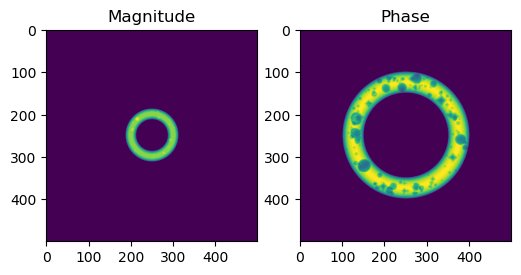

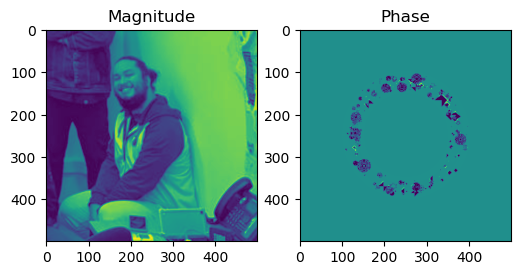

In [232]:
if 0:
    params = { 'HowMany': 3,
               'radius': 0.02,
               'Rtorus': 0.2,
               'rtorus': 0.05}
    phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
    magnitude = phantom1 + phantom2

    params = { 'HowMany': 10,
               'radius': 0.07,
               'Rtorus': 0.5,
               'rtorus': 0.1}
    phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
    phase = phantom1 + phantom2
    
    phantom = magnitude*np.exp(1j*phase)

    phantom = np.swapaxes(phantom,1,0)
    # phantom = phantom[:,:,0:450]
    # phantom = np.roll(phantom,-20,axis=2)    
    
    np.save(os.path.join(path,'complex_phantom.npy'),phantom)
else:
    phantom = np.load(os.path.join(path,'complex_phantom.npy'))

print(phantom.shape)
magnitude = np.abs(phantom)
phase = np.angle(phantom)
    
figure, ax = plt.subplots(1,2,dpi=100)
ax[0].imshow(np.sum(magnitude,axis=0)), ax[0].set_title('Magnitude')
ax[1].imshow(np.sum(phase,axis=0)), ax[1].set_title('Phase')


############

if 1: 
    phantom = np.ones(phantom.shape,dtype=complex)
    magnitude = np.array(Image.open('bernardi.png' ).convert('L').resize((phase.shape[2],phase.shape[1])))
    # phase = np.array(Image.open('bernardi.png' ).convert('L').resize((phase.shape[2],phase.shape[1])))
    # phase = np.flip(phase,axis=0)
    # phase = np.array(np.load('image.npy')) # Load Imagem
    
    phase = np.sum(phase,axis=0)
    magnitude = magnitude/np.max(magnitude)
    # phase = phase - np.min(phase)
    # phase = 2*np.pi*phase/np.max(phase) - np.pi # rescale from 0 to 2pi
    for i in range(phantom.shape[0]):
        phantom[i,:,:] = magnitude*np.exp(1j*phase)

    magnitude = np.abs(phantom)
    phase = np.angle(phantom)
    figure, ax = plt.subplots(1,2,dpi=100)
    ax[0].imshow(np.sum(magnitude,axis=0)), ax[0].set_title('Magnitude')
    ax[1].imshow(np.sum(phase,axis=0)), ax[1].set_title('Phase')

## Rotate and get projections 

In [233]:
angles = np.linspace(0,180,2*N)
angles = np.array([0])

get_projection_partial = partial(get_projection,magnitude=magnitude,phase=phase)

if 1:
    sinogram = np.zeros((angles.shape[0],phantom.shape[1],phantom.shape[2]),dtype=complex)
    processes = min(os.cpu_count(),32)
    print(f'Using {processes} parallel processes')
    with ProcessPoolExecutor(max_workers=processes) as executor:
        results = list(tqdm(executor.map(get_projection_partial,angles),total=len(angles)))
        for counter, result in enumerate(results):
            if counter % 100 == 0: print('Populating results matrix...',counter)
            sinogram[counter,:,:] = result
    np.save(os.path.join(path,'complex_sinogram.npy'),sinogram)
else:
    sinogram = np.load(os.path.join(path,'complex_sinogram.npy'))
sinogram.shape

Using 32 parallel processes


100%|██████████| 1/1 [00:46<00:00, 46.95s/it]


Populating results matrix... 0


(1, 500, 500)

## Probe and Diffraction Patterns

In [234]:
if 0:
    """ Realistic Probe """
    probe = np.load('probe_at_focus_1.25156micros_pixel.npy')
    probe.resize((probe.shape[0]//rescaling_factor,probe.shape[1]//rescaling_factor)) 
else:
    """ Round probe """
    probe = np.ones((100,100))
    xprobe = np.linspace(0,probe.shape[0]-1,probe.shape[0])
    xprobe -= probe.shape[0]//2
    Y,X = np.meshgrid(xprobe,xprobe)
    probe = np.where(X**2+Y**2<=45**2,1,0)
    
# plt.figure()
# plt.imshow(probe)
# plt.show()
    
print("Probe shape", probe.shape)

obj_pxl   = get_object_pixel(probe.shape[0],probe_pxl,wavelength,distance)
print(obj_pxl)

real_space_shape = (int(phantom.shape[0]+probe.shape[0]//2),int(phantom.shape[1]+probe.shape[1]//2))

save_hdf_masks(path,probe.shape)

""" Loop through all frames"""
for i in range(sinogram.shape[0]):
    if i%10==0: print(f"Creating dataset {i}/{sinogram.shape[0]}")
    filename = str(i).zfill(4)+f"_complex_phantom"
    # difpads = get_difpads(sinogram[i],probe,distance,energy,probe_pxl,real_space_shape,filename,path,oversampling=3)
    difpads = get_difpads2(sinogram[i],probe,obj_pxl,wavelength,distance,filename,path)

    """ Save to hdf file """
    create_hdf_file(difpads,path,filename)

    difpads = np.squeeze(difpads)
    np.save(os.path.join("/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/complex_phantom",f'{filename}_001.hdf5.npy'),difpads)
    np.save(os.path.join("/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/",f'{filename}_001.hdf5.npy'),difpads)
print("Done")

Probe shape (100, 100)
8.844975569504211e-08
Creating dataset 0/1
(610, 610)
(610, 610)
[  0  11  20  30  41  51  61  72  81  92 102 110 120 131 141 150 162 172
 182 190 202 212 222 231 240 250 262 272 282 290 302 310 320 332 340 350
 361 371 381 391 400 412 421 432 442 451 460 470 480 492 502]
[  0   9  20  30  38  49  59  69  79  88  98 110 119 128 140 148 160 168
 179 190 198 210 218 230 240 249 258 269 278 289 298 309 318 328 339 349
 358 368 380 389 400 410 418 430 438 450 458 470 478 489 498]
Reading probe positions (probe_positions)...
(2601, 1, 100, 100) (610, 610)
Done


In [228]:
def set_object_size_pxls(x_pos,y_pos,probe_size,gap=10):
    return (np.int(gap + probe_size[0]+(np.max(y_pos)-np.min(y_pos))),np.int(gap+probe_size[1]+(np.max(x_pos)-np.min(x_pos))))

print(phantom.shape,probe.shape,600,550)

def get_difpads2(frame,probe,obj_pxl,wavelength,distance,filename,path):

    
    dx, dy = 10, 10 # INPUT
    y_pxls = np.arange(0,phantom.shape[1]+1,dy)
    x_pxls = np.arange(0,phantom.shape[2]+1,dx)
    # print(y_pxls)
    # print(x_pxls)

    obj_size = set_object_size_pxls(x_pxls,y_pxls,probe.shape)
    print(obj_size)

    obj = np.zeros(obj_size,dtype=complex)
    obj[5:5+frame.shape[0],5:5+frame.shape[1]] = frame
    print(obj.shape)
    
    random_shift_range = 3 #INPUT
    random_shift_y = [np.int(i) for i in (-1)**np.int(2*np.random.rand(1))*random_shift_range*np.random.rand(y_pxls.shape[0])] # generate random shift between -N and +N
    random_shift_x = [np.int(i) for i in (-1)**np.int(2*np.random.rand(1))*random_shift_range*np.random.rand(x_pxls.shape[0])]

    y_pxls, x_pxls = random_shift_y + y_pxls, random_shift_x + x_pxls
    y_pxls, x_pxls = y_pxls - np.min(y_pxls), x_pxls - np.min(x_pxls)
    print(y_pxls)
    print(x_pxls)
    Y_pxls, X_pxls = np.meshgrid(y_pxls,x_pxls)

    if 0:
        """ Check if image is correctly sampled """
        test_frame = np.zeros_like(frame)
        for y,x in zip(Y_pxls.flatten(),X_pxls.flatten()):
            test_frame[y:y+probe.shape[0],x:x+probe.shape[1]] = frame[y:y+probe.shape[0],x:x+probe.shape[1]]

        figure, ax = plt.subplots(1,3,dpi=100)
        ax1, ax2, ax3 = ax.ravel()
        ax1.imshow(frame)
        ax2.imshow(test_frame)
        ax3.imshow(frame-test_frame)
        print(np.all(frame-test_frame)==0)
        plt.show(), plt.close()

    """ Convert to metric units """
    x_meters, y_meters = x_pxls*obj_pxl , y_pxls*obj_pxl
    artificial_shift = x_meters[0]
    x_meters, y_meters = x_meters - artificial_shift, y_meters - artificial_shift
    # print(y_meters)
    # print(x_meters)

    save_positions_file_CAT_standard(x_meters,y_meters,path,filename)
    probe_positions = read_probe_positions(path,filename)

    # probe_positions, _ = convert_probe_positions(obj_pxl, probe_positions,offset_topleft=0)
    # print(probe_positions)
    # y_pos_pxl, x_pos_pxl = probe_positions[:,1], probe_positions[:,0]
    # print(np.min(y_pos_pxl),np.min(x_pos_pxl))
    # print(x_pos_pxl)
    # y_pos_pxl = [np.int(np.round(i)) for i in y_pos_pxl[0:y_pxls.shape[0]]]
    # x_pos_pxl = [np.int(np.round(i)) for i in x_pos_pxl[::y_pxls.shape[0]]]
    # print(x_pos_pxl)
    # print(y_pos_pxl-y_pxls)
    # print(x_pos_pxl-x_pxls)
    # print(x_pos_pxl)
    # x_pos_pxl
    
    """ Loop through positions """ 
    difpads = np.zeros((X_pxls.flatten().shape[0],1,probe.shape[0],probe.shape[1]))
    print(difpads.shape,obj.shape)
    counter = 0
    calculate_diffraction_pattern_partial = partial(calculate_diffraction_pattern,obj=obj,probe=probe,wavelength=wavelength,distance=distance,obj_pxl=obj_pxl)
    # idx_list = [ [y,x] for y, x in zip(Y_pxls.flatten(),X_pxls.flatten()) ]
    idx_list = [ [x,y] for y, x in zip(Y_pxls.flatten(),X_pxls.flatten()) ]
    processes = min(os.cpu_count(),32)
    with ProcessPoolExecutor(max_workers=processes) as executor:
        results = executor.map(calculate_diffraction_pattern_partial,idx_list)
        for counter, result in enumerate(results):
            difpads[counter,0,:,:] = result
    return difpads

print(wavelength)
print(obj_pxl)
print(probe_pxl)
# frame = np.sum(np.angle(phantom),axis=0)
# filename = str(0).zfill(4)+f"_complex_phantom"
# difpads = get_difpads2(frame,probe,obj_pxl,wavelength,distance,filename,path)

(500, 500, 500) (100, 100) 600 550
1.7712028198029904e-10
1.7689951139008422e-08
2.002496e-05
